# Learning Outcomes
We will be focusing on image segmentation algorithms:
- K-means clustering
- anisotropic segmentation
- watershed segmentation

## setup

In [1]:
!pip install requests

In [2]:
import sys
assert sys.version_info >= (3, 7)

import numpy as np
import cv2 as cv
from util_func import *

## Simple demo of k-means clustering

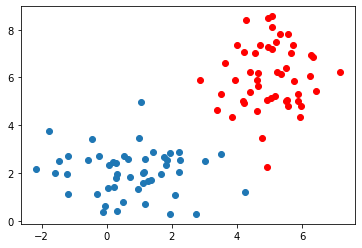

In [14]:
# define bivariate Gaussian distribution function and sample
mean1 = (1, 2)
cov1 = np.array([[2, 0], [0, 1]])
dat1 = np.random.multivariate_normal(mean1, cov1, size=50)  # data1

# cluster2
mean2 = (5, 6)
cov2 = np.array([[1, 0], [0, 2]])
dat2 = np.random.multivariate_normal(mean2, cov2, size=50)  # data2

# concatenate dat1 and dat2 into 1 array (1 matrix)
data = np.concatenate((dat1, dat2), axis=0)  # concatenate by sample numbers

plt.scatter(dat1[:, 0], dat1[:, 1])    # x and y axis for data1
plt.scatter(dat2[:, 0], dat2[:, 1], c = "r")    # x and y axis for data2
plt.show()

In [9]:
dat1.shape

(50, 2)

In [5]:
dat2.shape

(50, 2)

In [10]:
data.shape

(100, 2)

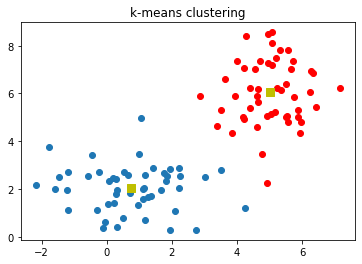

In [20]:
# k-means clustering: sklearn, cv
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)

# input data should be float32
Z = np.float32(data)
ret, label, center = cv.kmeans(Z, 2, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)    # 10 repetitions

# subset the data with label 0 and 1
A = Z[label.ravel() == 0]    # flatten the label become 100 only (do not have 1 at behind)
B = Z[label.ravel() == 1]

plt.scatter(A[:, 0], A[:, 1])
plt.scatter(B[:, 0], B[:, 1], c = "r")
plt.scatter(center[:, 0], center[:, 1], c = "y", s=80, marker="s")
plt.title("k-means clustering")
plt.show()

In [17]:
np.unique(label)

array([0, 1], dtype=int32)

In [18]:
label.shape

(100, 1)

### Demo of color image (k-means clustering)

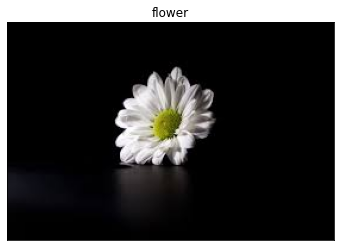

In [21]:
img = cv.imread("images/flower.jfif")
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt_img(img_rgb, "flower")

In [23]:
def k_means_clust(img, K, max_iter=10, eps=1.0, attempts=10, flag=cv.KMEANS_PP_CENTERS):
    """Args
    img: color image (3 channel)
    K = number of clusters
    By default, max_iter=10, eps=1, attempts=10, k-means++
    """
    img = img.reshape((-1, 3))   # reshape image into matrix - > move the RGB value from 3 channels into 1 matrix
    img = np.float32(img)
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, max_iter, eps)
    return cv.kmeans(img, K, None, criteria, attempts, flag)

ret, label, center = k_means_clust(img_rgb, 3)

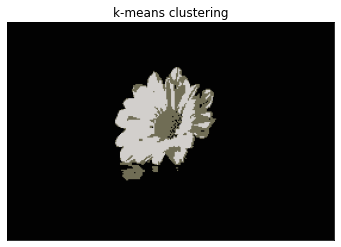

In [24]:
# propagate center back into the image
center = np.uint8(center)       # represent center as image -> need to change it back to uint8

res = center[label.flatten()]   # or label.ravel()
quant = res.reshape(img_rgb.shape)

plt_img(quant, "k-means clustering")

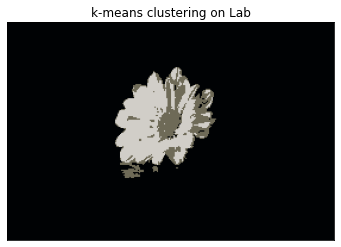

In [29]:
# lab is the best color representation for k-means clustering because of perceptual uniformity
img_lab = cv.cvtColor(img, cv.COLOR_BGR2Lab)

ret, label, center = k_means_clust(img_lab, 3)

center = np.uint8(center)       # represent center as image -> need to change it back to uint8

res = center[label.flatten()]   # or label.ravel()
quant = res.reshape(img_lab.shape)

# change from lab to rgb
quant_rgb = cv.cvtColor(quant, cv.COLOR_Lab2RGB)
plt_img(quant_rgb, "k-means clustering on Lab")

## Anisotropic segmentation

In [31]:
def calcGST(inputIMG, w, method_edge="scharr"):
    img = np.float32(inputIMG)
    
    # Gradient structure tensor components
    if method_edge == 'scharr':
        imgDiffX = cv.Scharr(img, cv.CV_32F, 1, 0)
        imgDiffY = cv.Scharr(img, cv.CV_32F, 0, 1)
    elif method_edge == 'sobel':
        imgDiffX = cv.Sobel(img, cv.CV_32F, 1, 0)
        imgDiffY = cv.Sobel(img, cv.CV_32F, 0, 1)
    else:
        raise Exception("no edge detection method available")
    
    imgDiffXY = cv.multiply(imgDiffX, imgDiffY)
    imgDiffXX = cv.multiply(imgDiffX, imgDiffX)
    imgDiffYY = cv.multiply(imgDiffY, imgDiffY)
    
    J11 = cv.boxFilter(imgDiffXX, cv.CV_32F, (w, w))
    J22 = cv.boxFilter(imgDiffYY, cv.CV_32F, (w, w))
    J12 = cv.boxFilter(imgDiffXY, cv.CV_32F, (w, w))
    
    # eigenvalue
    tmp1 = J11+J22
    tmp2 = J11-J22
    tmp2 = cv.multiply(tmp2, tmp2)
    tmp3 = cv.multiply(J12, J12)
    tmp4 = np.sqrt(tmp2 + 4.0*tmp3)
    
    lambda1 = 0.5*(tmp1+tmp4)
    lambda2 = 0.5*(tmp1 - tmp4)
    
    # coherency
    imgCoherencyOut = cv.divide(lambda1-lambda2, lambda1+lambda2)
    
    # orientation calculation
    imgOrientationOut = cv.phase(J22-J11, 2.0*J12, angleInDegrees = True)
    imgOrientationOut = 0.5*imgOrientationOut
    
    return imgCoherencyOut, imgOrientationOut

You can use `cv.Gaussian()` in line 18-20, instead of `cv.boxFilter()`. But you have to keep in mind of the zero division problem in line 36. Add small constant on denominator.

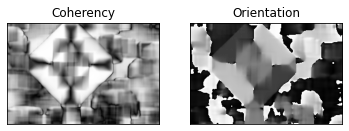

In [33]:
# visualize coherency and orientation map
img = cv.imread("images/traffic_sign.jfif")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
blur =cv.GaussianBlur(gray, (5, 5), 0)

W = 25
imgCoherency, imgOrientation = calcGST(blur, W)

# normalize coherency and orientation in order to visualize them
imgCoherency_norm = cv.normalize(imgCoherency, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
imgOrientation_norm = cv.normalize(imgOrientation, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)

plt.subplot(121), plt_img(imgCoherency_norm, "Coherency")
plt.subplot(122), plt_img(imgOrientation_norm, "Orientation")
plt.show()

In [1]:
import cv2 as cv
import numpy as np

def nothing(x):
    pass

# Set up trackbars
wn = "Anisotropic segmentation"
cv.namedWindow(wn, cv.WINDOW_NORMAL | cv.WINDOW_FREERATIO)
cv.createTrackbar("Coherency threshold 1", wn, 50, 100, nothing)
cv.createTrackbar("Coherency threshold 2", wn, 70, 100, nothing)
cv.createTrackbar("Orientation threshold 1", wn, 50, 180, nothing)
cv.createTrackbar("Orientation threshold 2", wn, 100, 180, nothing)

# Load image and preprocess
img = cv.imread("images/traffic_sign.jfif")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
blur = cv.GaussianBlur(gray, (5, 5), 0)

# Dummy calcGST function
def calcGST(image, window_size):
    imgCoherency = np.random.rand(*image.shape)
    imgOrientation = np.random.rand(*image.shape)
    return imgCoherency, imgOrientation

# Computation of GST
W = 27
imgCoherency, imgOrientation = calcGST(blur, W)

while True:
    # Get threshold values from trackbars
    th_C_1 = cv.getTrackbarPos("Coherency threshold 1", wn) * 0.01
    th_C_2 = cv.getTrackbarPos("Coherency threshold 2", wn) * 0.01
    th_Or_1 = cv.getTrackbarPos("Orientation threshold 1", wn) * 0.01
    th_Or_2 = cv.getTrackbarPos("Orientation threshold 2", wn) * 0.01
    
    # Thresholding
    imgBin_C_1 = cv.threshold(imgCoherency, th_C_1, 255, cv.THRESH_BINARY)[1]
    imgBin_C_2 = cv.threshold(imgCoherency, th_C_2, 255, cv.THRESH_BINARY_INV)[1]
    imgBin_Or_1 = cv.threshold(imgOrientation, th_Or_1, 255, cv.THRESH_BINARY)[1]
    imgBin_Or_2 = cv.threshold(imgOrientation, th_Or_2, 255, cv.THRESH_BINARY_INV)[1]
    
    # Merge binary maps
    imgBin_C = cv.bitwise_and(imgBin_C_1, imgBin_C_2)
    imgBin_Or = cv.bitwise_and(imgBin_Or_1, imgBin_Or_2)
    
    # Final mask
    imgBin = cv.bitwise_and(imgBin_C, imgBin_Or)
    
    # Display segmentation result
    mask = imgBin != 0
    res = img * (mask[:, :, None].astype(np.uint8))
    cv.imshow(wn, res)
    cv.imshow("segmentation mask", imgBin)
    
    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break
        
cv.destroyAllWindows()


error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window_w32.cpp:2561: error: (-27:Null pointer) NULL window: 'Anisotropic segmentation' in function 'cvGetTrackbarPos'


## Watershed segmentation on traffic sign images

In [3]:
# have to download scikitImage in PC since we are not using OpenCV in this method
# because OpenCV ONLY support COLOR SCALE IMAGE for watershed segmentation

img = cv.imread("images/traffic_sign.jfif")

show_img("img", img)

In [4]:
# gaussian blurring
blur = cv.GaussianBlur(img, (5, 5), 0)
# mean shift segmentation
blur = cv.pyrMeanShiftFiltering(blur, 15, 20, maxLevel=2)

show_img("mean shift", blur)

In [6]:
# grayscale
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)

# morphological gradient (edge, local maximum)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (11, 11))
loc_grad = cv.morphologyEx(gray, cv.MORPH_GRADIENT, kernel, iterations=2)

show_img("gradient", loc_grad)

In [7]:
# import libraries
from scipy import ndimage as ndi     # label marker (boolean)
from skimage.segmentation import watershed

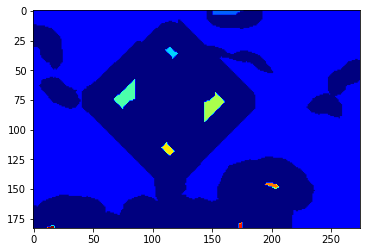

In [8]:
# th
th = loc_grad < 80   # boolean
s = np.ones((3, 3), dtype=int)
marker = ndi.label(th, structure=s)[0]   # there are 2 outputs, we just want the first one [0]

plt.imshow(marker, cmap="jet")
plt.show()

# construction of marker will be shown

In [9]:
# topographic surface
edge = cv.Canny(gray, 250, 500)

labels = watershed(edge, marker)

np.unique(labels, return_counts=True)

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([40736,   279,  1234,  2325,  2295,  1270,  1066,   736,   384],
       dtype=int64))

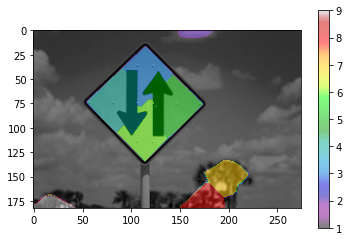

In [10]:
plt.figure()

gray_ori = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.imshow(gray_ori, cmap="gray")
plt.imshow(labels, cmap=plt.cm.nipy_spectral, alpha=0.5)
plt.colorbar()
plt.show()

In [14]:
# remove background. assumption: background has largest area
label_vec, counts = np.unique(labels, return_counts=True)

label_bg = label_vec[np.argmax(counts)]

mask = 255*np.ones(labels.shape, dtype=np.uint8)  # everything is white except background

mask[labels==label_bg] = 0

# find contour
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# find the largest contour
contour = sorted(contours, key=cv.contourArea, reverse=True)[0]

img_copy = img.copy()
cv.drawContours(img_copy, [contour], -1, (0, 255, 0), 2)

show_img("watershed", img_copy)

In [25]:
img_copy = img.copy()

x, y, w, h = cv.boundingRect(contour)
cv.rectangle(img_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)

show_img("bounding box", img_copy)

In [12]:
label_bg

1

### Example 4

In [15]:
img = cv.imread("images/traffic_sign1.jpg")
(h, w) = img.shape[:2]
blur = cv.GaussianBlur(img, (5, 5), 0)

In [16]:
# Convert to Lab
img_lab = cv.cvtColor(blur, cv.COLOR_BGR2Lab)

img_lab = img_lab.reshape((h*w, 3))
img_lab = np.float32(img_lab)
# criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
flags = cv.KMEANS_PP_CENTERS

compactness, labels, centers = cv.kmeans(img_lab, 10, None, criteria, 10, flags)

quant = centers.astype(np.uint8)[labels]
quant = quant.reshape((h, w, 3))

bgr = cv.cvtColor(quant, cv.COLOR_Lab2BGR)

show_img("kmeans quantization", bgr)

In [17]:
img_lab[..., 0].min()

6.0

In [18]:
gray = cv.cvtColor(bgr, cv.COLOR_BGR2GRAY)

th = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_OTSU)[1]

show_img("threshold", th)

In [19]:
from skimage.feature import peak_local_max

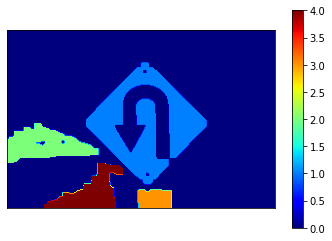

In [22]:
kernel = np.ones((3, 3), dtype=np.uint8)
th = cv.morphologyEx(th, cv.MORPH_OPEN, kernel, iterations=3)

dist_transform = cv.distanceTransform(th, cv.DIST_L2, 3)

coords = peak_local_max(dist_transform, footprint=np.ones((100, 100)), labels=th)

mask = np.zeros(dist_transform.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-dist_transform, markers, mask=th)

plt.imshow(labels, cmap=plt.cm.jet)
plt.colorbar(), plt.xticks([]), plt.yticks([])
plt.show()

In [26]:
# remove background
label_vec, counts = np.unique(labels, return_counts=True)

label_bg = label_vec[np.argmax(counts)]

mask = 255*np.ones(labels.shape, dtype=np.uint8)

mask[labels==label_bg] = 0

# find contour
contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# find the largest contour
contour = sorted(contours, key=cv.contourArea, reverse=True)[0]

img_copy = img.copy()
cv.drawContours(img_copy, [contour], -1, (0, 255, 0), 2)

show_img("watershed", img_copy)

In [27]:
img_copy = img.copy()

x, y, w, h = cv.boundingRect(contour)
cv.rectangle(img_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)

show_img("bounding box", img_copy)

## Exercise

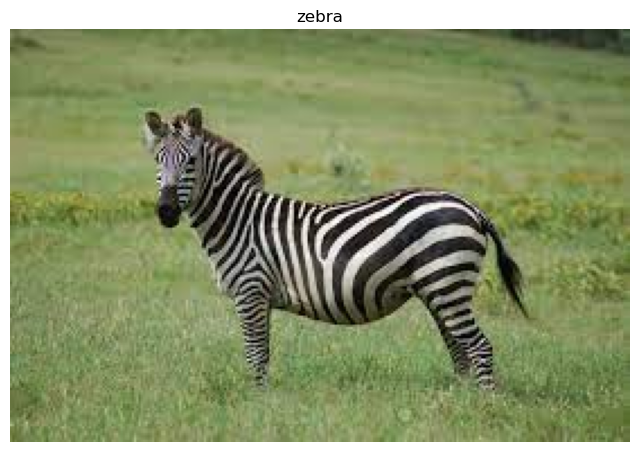

C:\Users\huisi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


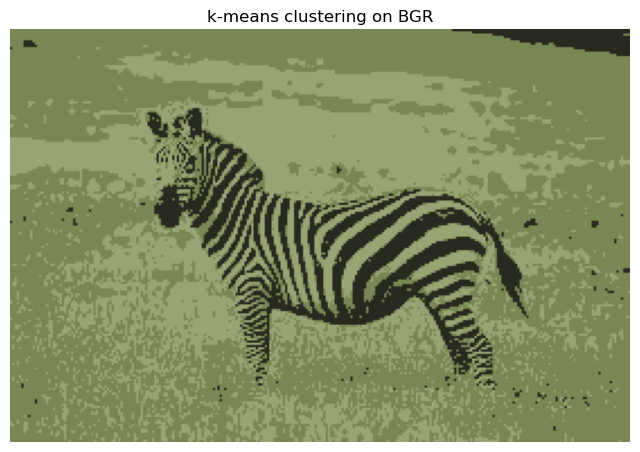

C:\Users\huisi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


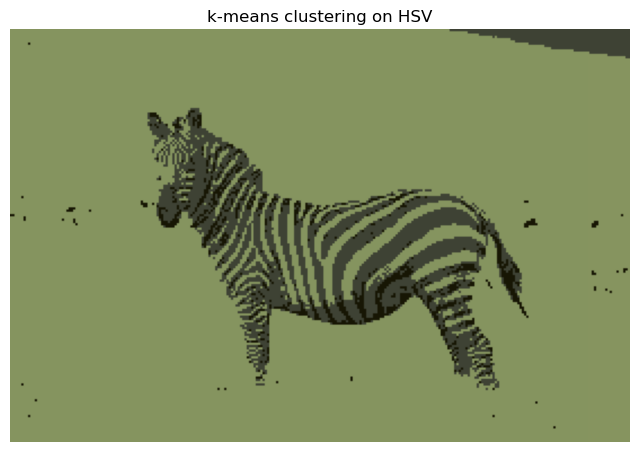

C:\Users\huisi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


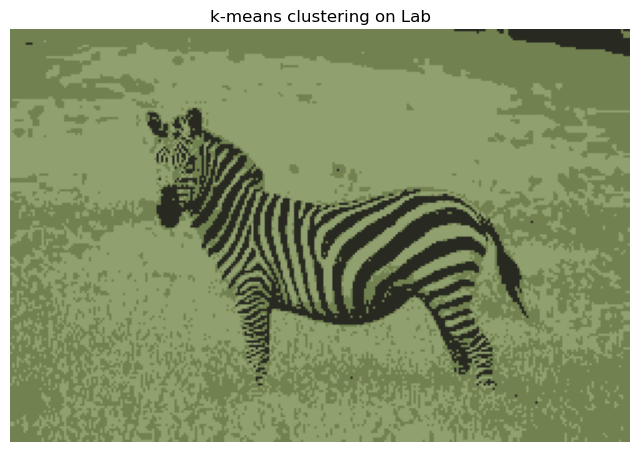

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def plt_img(image, title):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.show()

def k_means_clust(image, k):
    pixels = image.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(pixels)
    label = kmeans.predict(pixels)
    center = kmeans.cluster_centers_
    return label, center

img = cv2.imread("images/zebra.jfif")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt_img(img_rgb, "zebra")

# Apply k-means clustering on BGR
label, center = k_means_clust(img_rgb, 3)
center = np.uint8(center)
quant = center[label.flatten()].reshape(img_rgb.shape)
plt_img(quant, "k-means clustering on BGR")

# Apply k-means clustering on HSV
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
label, center = k_means_clust(img_hsv, 3)
center = np.uint8(center)
quant_hsv = center[label.flatten()].reshape(img_hsv.shape)
quant_rgb_hsv = cv2.cvtColor(quant_hsv, cv2.COLOR_HSV2RGB)
plt_img(quant_rgb_hsv, "k-means clustering on HSV")

# Apply k-means clustering on Lab
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
label, center = k_means_clust(img_lab, 3)
center = np.uint8(center)
quant_lab = center[label.flatten()].reshape(img_lab.shape)
quant_rgb_lab = cv2.cvtColor(quant_lab, cv2.COLOR_Lab2RGB)
plt_img(quant_rgb_lab, "k-means clustering on Lab")
